In [10]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau
from pathlib import Path
from typing import Optional, List
outputs_dir = Path("outputs_score")

In [16]:
df_a = pd.read_excel(outputs_dir/'results/ARIADNE_data.xlsx')
#  chrpsychs_scr_1d1 (severity) and chrpsychs_scr_1d2 (frequency).
df_eval = df_a[['interview_date','src_subject_id','chrpsychs_scr_1d1','chrpsychs_scr_1d2','visit']].copy()
df_eval = df_eval.iloc[1:].reset_index()
df_eval = df_eval.rename(columns={"chrpsychs_scr_1d1": "severity", "chrpsychs_scr_1d2": "frequency"})

In [3]:
def extract_subject_and_model(filename: str):
    """
    Extract subject ID (2nd underscore item), day, session, and clean model name.
    Example filename:
      PrescientBM_BM13061_interviewAudioTranscript_psychs_day0001_session001_REDACTED_assessment_Dom_v2_qwen3.txt
    """
    parts = filename.split("_")
    subj = parts[1] if len(parts) > 1 else None

    # Extract day and session numbers
    day_match = re.search(r"day(\d+)", filename)
    session_match = re.search(r"session(\d+)", filename)
    day = int(day_match.group(1)) if day_match else None
    session = int(session_match.group(1)) if session_match else None

    # Extract model name and clean prefix like v2_
    m = re.search(r"assessment_[^_]+_([^./]+)", filename)
    model = m.group(1) if m else "unknown"
    model = re.sub(r"^v\d+_", "", model)

    return subj, day, session, model

def extract_two_scores(text: str):
    """
    Robustly extract CAARMS-style scores:
      **Severity Rating**: **3 (Moderate)**
      **Frequency Rating**: **3 (1 day/month to 2 days/week – <1 hour/day)**
    - Ignores 'CAARMS 2023', 'rated 70/100', etc.
    - Works with or without Markdown bold.
    """

    # Normalize: collapse whitespace, lowercase
    s = re.sub(r"\s+", " ", text).lower()

    # Helper: find first small integer (0–6) close to a label
    def _grab(label: str):
        patterns = [
            # Markdown-bolded label and/or value; allow :, =, -, en/em-dash
            rf"(?:\*{{0,3}}\s*)?{label}(?:\s*rating)?(?:\s*\*{{0,3}})?\s*[:=\-–—]\s*(?:\*{{0,3}}\s*)?([0-6](?:\.\d+)?)\b",
            # Plain text label; capture a digit within a short window after the label
            rf"\b{label}(?:\s*rating)?\b[^0-9]{{0,10}}([0-6](?:\.\d+)?)\b",
        ]
        for pat in patterns:
            m = re.search(pat, s)
            if m:
                try:
                    val = float(m.group(1))
                    if 0 <= val <= 6:
                        return val
                except Exception:
                    pass
        return None

    sev = _grab("severity")
    freq = _grab("frequency")

    # Final guard (real reassignment)
    if sev is not None and not (0 <= sev <= 6):
        sev = None
    if freq is not None and not (0 <= freq <= 6):
        freq = None

    return sev, freq

In [22]:

records = []
target_model = "gpt-oss:20b"      # e.g., "qwen3", "gpt-oss:20b", or "all"
prompt_name = "Dom_v2"      # e.g., "Dom_v2", "Dom_v3", etc.

# Flexible glob pattern: model and prompt both optional
pattern = "*assessment_"
pattern += f"{prompt_name}_"
pattern += f"{target_model}"
pattern += ".txt"

print(f"\n🔍 Searching for files matching: {pattern}")

for f in outputs_dir.glob(pattern):
    text = f.read_text(encoding="utf-8", errors="ignore")

    subj, day, session, model = extract_subject_and_model(f.name)
    sev, freq = extract_two_scores(text)

    
    if sev == None or freq==None:
        print('File of texts with nan values parsed: ')
        print(f)

    records.append({
        "src_subject_id": subj,
        "day": day,
        "session": session,
        "model": model,
        "prompt": prompt_name,
        "severity_pred": sev,
        "frequency_pred": freq
    })

df_pred = pd.DataFrame(records)
print(f"\n📄 Extracted {len(df_pred)} predictions (model={target_model}, prompt={prompt_name})")
print(df_pred.head())


🔍 Searching for files matching: *assessment_Dom_v2_gpt-oss:20b.txt
File of texts with nan values parsed: 
outputs_score/PronetNC_NC30190_interviewAudioTranscript_psychs_day0001_session001_REDACTED_assessment_Dom_v2_gpt-oss:20b.txt
File of texts with nan values parsed: 
outputs_score/PrescientME_ME75545_interviewAudioTranscript_psychs_day0001_session001_REDACTED_assessment_Dom_v2_gpt-oss:20b.txt
File of texts with nan values parsed: 
outputs_score/PronetWU_WU01590_interviewAudioTranscript_psychs_day0086_session003_REDACTED_assessment_Dom_v2_gpt-oss:20b.txt
File of texts with nan values parsed: 
outputs_score/PrescientME_ME99125_interviewAudioTranscript_psychs_day0028_session001_REDACTED_assessment_Dom_v2_gpt-oss:20b.txt
File of texts with nan values parsed: 
outputs_score/PrescientSG_SG34238_interviewAudioTranscript_psychs_day0106_session002_REDACTED_assessment_Dom_v2_gpt-oss:20b.txt
File of texts with nan values parsed: 
outputs_score/PrescientME_ME69871_interviewAudioTranscript_psych

In [5]:
# add manual scores for qwen 3
# df_pred.loc[df_pred['src_subject_id'] == 'SG71850', 'frequency_pred'] = 5
# df_pred.loc[((df_pred['src_subject_id'] == 'ME19909')&(df_pred['day']==72)), 'frequency_pred'] = 0
# df_pred.loc[((df_pred['src_subject_id'] == 'PI26395')&(df_pred['day']==16)&(df_pred['session']==2)), 'frequency_pred'] = 0
# df_pred.loc[((df_pred['src_subject_id'] == 'PI26395')&(df_pred['day']==16)&(df_pred['session']==2)), 'severity_pred'] = 0

In [24]:
# Define target columns
cols = ["severity_pred", "frequency_pred"]

# Filter rows where either column is NaN
nan_rows = df_pred[df_pred[cols].isna().any(axis=1)]

# Print summary and rows
print(f"🔍 Found {len(nan_rows)} rows with missing severity or frequency scores.\n")
print(nan_rows.to_string(index=False))

df_pred[cols] = df_pred[cols].fillna(0)

🔍 Found 112 rows with missing severity or frequency scores.

src_subject_id   day  session       model prompt  severity_pred  frequency_pred
       NC30190   1.0        1 gpt-oss:20b Dom_v2            NaN             4.0
       ME75545   1.0        1 gpt-oss:20b Dom_v2            NaN             NaN
       WU01590  86.0        3 gpt-oss:20b Dom_v2            NaN             NaN
       ME99125  28.0        1 gpt-oss:20b Dom_v2            NaN             NaN
       SG34238 106.0        2 gpt-oss:20b Dom_v2            NaN             NaN
       ME69871   1.0        1 gpt-oss:20b Dom_v2            NaN             0.0
       GA24425  88.0        5 gpt-oss:20b Dom_v2            NaN             3.0
       NL10958   1.0        1 gpt-oss:20b Dom_v2            NaN             NaN
       KC06453   1.0        1 gpt-oss:20b Dom_v2            NaN             NaN
       GA25657  52.0        2 gpt-oss:20b Dom_v2            NaN             NaN
       PA15669   1.0        1 gpt-oss:20b Dom_v2           

In [25]:
# Subset each DataFrame
df_pred_day1 = df_pred[df_pred["day"] == 1]
df_eval_baseline = df_eval[df_eval["visit"] == "baseline"]

# Merge on subject ID
df_merged_day1 = pd.merge(
    df_pred_day1,
    df_eval_baseline,
    on="src_subject_id",
    how="inner"   # only subjects present in both
)

print(f"✅ Merged {len(df_merged_day1)} rows (day=1 × baseline).")
print(df_merged_day1.head())

out_file = outputs_dir / f"results/score_baseline_{prompt_name}_{target_model}.csv"

# Save only if file does not already exist
if not out_file.exists():
    df_merged_day1.to_csv(out_file, index=False)
    print(f"✅ Saved: {out_file}")
else:
    print(f"⚠️ File already exists, not overwritten: {out_file}")

✅ Merged 135 rows (day=1 × baseline).
  src_subject_id  day  session        model  prompt  severity_pred  \
0        PA02303  1.0        1  gpt-oss:20b  Dom_v2            5.0   
1        NC30190  1.0        1  gpt-oss:20b  Dom_v2            0.0   
2        WU01590  1.0        1  gpt-oss:20b  Dom_v2            5.0   
3        WU06851  1.0        1  gpt-oss:20b  Dom_v2            4.0   
4        ME23603  1.0        1  gpt-oss:20b  Dom_v2            2.0   

   frequency_pred  index       interview_date severity frequency     visit  
0             4.0   2727           01/25/2023        1         5  baseline  
1             4.0   2606           03/18/2024        6         5  baseline  
2             6.0   3864  2022-05-09 00:00:00        4         4  baseline  
3             2.0   3867  2022-07-10 00:00:00        2         3  baseline  
4             1.0   1184           02/27/2024        3         3  baseline  
✅ Saved: outputs_score/results/score_baseline_Dom_v2_gpt-oss:20b.csv


## Results analysis

In [26]:
out_file = outputs_dir / f"results/score_baseline_{prompt_name}_{target_model}.csv"
df = pd.read_csv(out_file)

✅ Remaining rows for analysis: 115
       severity_pred  frequency_pred    severity   frequency
count     115.000000      115.000000  115.000000  115.000000
mean        1.852174        1.904348    2.078261    2.121739
std         1.562968        1.685719    1.707300    1.707300
min         0.000000        0.000000    0.000000    0.000000
25%         0.000000        0.000000    0.000000    0.000000
50%         2.000000        2.000000    2.000000    2.000000
75%         3.000000        3.000000    3.000000    3.000000
max         6.000000        6.000000    6.000000    6.000000

📊 Correlation summary for Severity:
  Pearson r = 0.175 (p=0.0609)
  Spearman ρ = 0.165 (p=0.0787)
  Kendall τ = 0.138 (p=0.0644)

📊 Correlation summary for Frequency:
  Pearson r = 0.199 (p=0.0329)
  Spearman ρ = 0.212 (p=0.0227)
  Kendall τ = 0.166 (p=0.0255)


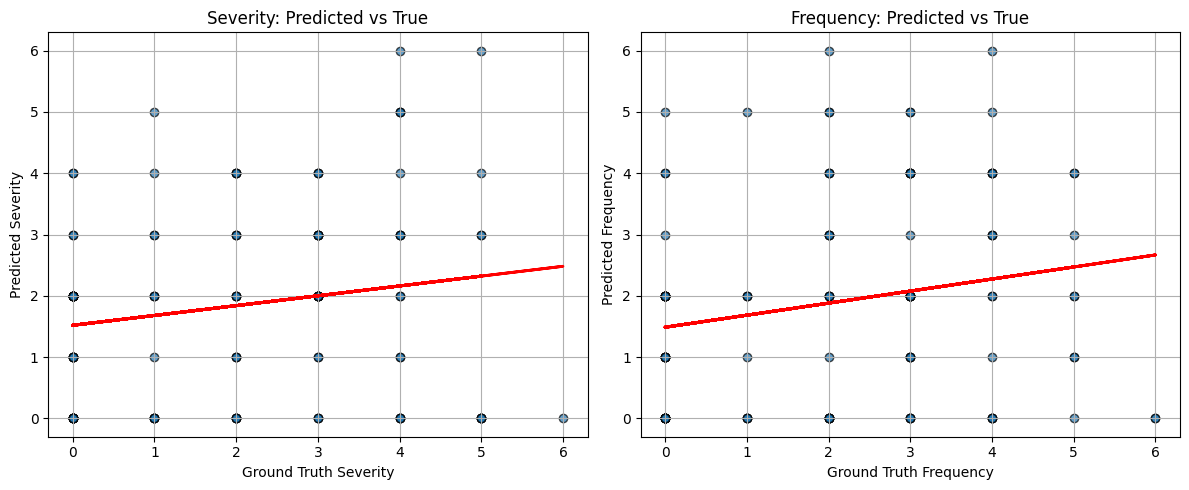

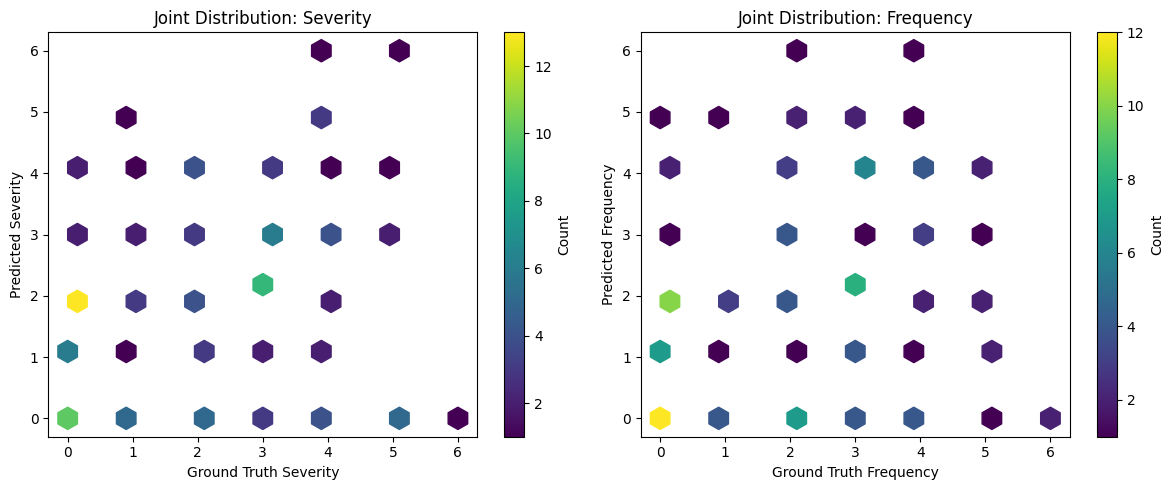

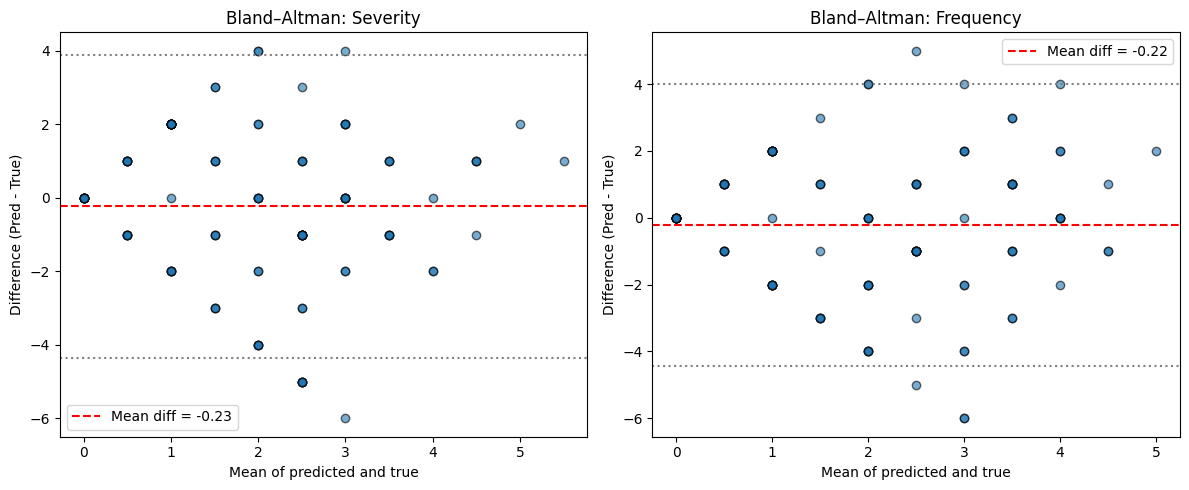

In [27]:
# DATA CLEANING
# =============================================

cols_to_fix = [pred_sev_col, pred_freq_col, gt_sev_col, gt_freq_col]

# Convert to numeric, forcing invalid strings (like "NA") to NaN
for c in cols_to_fix:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Keep only rows with all four valid numeric values
df = df.dropna(subset=cols_to_fix)

# Restrict to CAARMS scale (0–6) to avoid outliers like 2023
for c in cols_to_fix:
    df.loc[~df[c].between(0, 6, inclusive="both"), c] = np.nan

df = df.dropna(subset=cols_to_fix)

print(f"✅ Remaining rows for analysis: {len(df)}")
print(df[cols_to_fix].describe())

# =============================================
# CORRELATION ANALYSIS
# =============================================

def corr_summary(x, y, label):
    """Compute Pearson, Spearman, and Kendall correlations."""
    pearson_r, p_p = pearsonr(x, y)
    spearman_r, p_s = spearmanr(x, y)
    kendall_r, p_k = kendalltau(x, y)
    print(f"\n📊 Correlation summary for {label}:")
    print(f"  Pearson r = {pearson_r:.3f} (p={p_p:.4f})")
    print(f"  Spearman ρ = {spearman_r:.3f} (p={p_s:.4f})")
    print(f"  Kendall τ = {kendall_r:.3f} (p={p_k:.4f})")

corr_summary(df[pred_sev_col], df[gt_sev_col], "Severity")
corr_summary(df[pred_freq_col], df[gt_freq_col], "Frequency")

# =============================================
# SCATTER + REGRESSION PLOTS
# =============================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, (xcol, ycol, label) in zip(
    axes,
    [(gt_sev_col, pred_sev_col, "Severity"),
     (gt_freq_col, pred_freq_col, "Frequency")]
):
    ax.scatter(df[xcol], df[ycol], alpha=0.7, edgecolor="k")
    ax.set_xlabel(f"Ground Truth {label}")
    ax.set_ylabel(f"Predicted {label}")
    ax.set_title(f"{label}: Predicted vs True")
    # Regression line
    m, b = np.polyfit(df[xcol], df[ycol], 1)
    ax.plot(df[xcol], m * df[xcol] + b, color="red", linewidth=2)
    ax.grid(True)

plt.tight_layout()
plt.show()

# =============================================
# HEXBIN DENSITY PLOTS
# =============================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, (pred, gt, title) in zip(
    axes,
    [(pred_sev_col, gt_sev_col, "Severity"), (pred_freq_col, gt_freq_col, "Frequency")]
):
    hb = ax.hexbin(df[gt], df[pred], gridsize=20, cmap="viridis", mincnt=1)
    ax.set_xlabel(f"Ground Truth {title}")
    ax.set_ylabel(f"Predicted {title}")
    ax.set_title(f"Joint Distribution: {title}")
    fig.colorbar(hb, ax=ax, label="Count")

plt.tight_layout()
plt.show()

# =============================================
# BLAND–ALTMAN PLOTS
# =============================================

def bland_altman_plot(x, y, ax, title):
    diff = y - x
    mean = (x + y) / 2
    md = diff.mean()
    sd = diff.std()
    ax.scatter(mean, diff, alpha=0.6, edgecolor="k")
    ax.axhline(md, color="red", linestyle="--", label=f"Mean diff = {md:.2f}")
    ax.axhline(md + 1.96*sd, color="gray", linestyle=":")
    ax.axhline(md - 1.96*sd, color="gray", linestyle=":")
    ax.set_xlabel(f"Mean of predicted and true")
    ax.set_ylabel("Difference (Pred - True)")
    ax.set_title(title)
    ax.legend()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
bland_altman_plot(df[gt_sev_col], df[pred_sev_col], axes[0], "Bland–Altman: Severity")
bland_altman_plot(df[gt_freq_col], df[pred_freq_col], axes[1], "Bland–Altman: Frequency")
plt.tight_layout()
plt.show()
# %%